<a href="https://colab.research.google.com/github/ramdhanhdy/Ramdhan_Portfolio/blob/main/recommender_system_e_commerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependencies

### Dependencies

1. pandas
2. numpy
3. cudf
4. isotree
5. datawig
6. matplotlib

In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())


In [ ]:
#check if tensorflow or pytorch can use gpu

#import torch
#torch.cuda.is_available()

#import tensorflow as tf
#tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#Install on sys path
!pip install --target=$nb_path datawig

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

Mounted at /content/drive




## Set-Up


### Import Dataset from Kaggle

In [1]:
from google.colab import files
files.upload()

{}

In [2]:
!ls

 data		    kaggle.json			        sample_data
'kaggle (1).json'   recsys-2020-ecommerce-dataset.zip


In [3]:
!mkdir ~/.kaggle

In [6]:
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d dschettler8845/recsys-2020-ecommerce-dataset

recsys-2020-ecommerce-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! unzip recsys-2020-ecommerce-dataset.zip -d data

Archive:  recsys-2020-ecommerce-dataset.zip
replace data/test.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
!ls data

test.parquet  train.parquet  val.parquet


In [4]:
!nvidia-smi

Fri Mar 19 16:16:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Dataset Description

This file contaisn behavior data for 7 months (from October 2019 to April 2020) from a large multi-category online store.

Each row in the file represents an event. All events are related to products and users. Each event is like many-to-many relation between products and users.


|   Property	|  Description 	|
|---	|---	|
|   **event_time**	|   Time when event happened at (in UTC)	|
|   **event_type**	|   Only one kind of event: purchase	|
|   **product_id**	|   	ID of a product  |
|   **category_id**	|   Product's category ID	|
|   **category_code**	|  Product's category taxonomy (code name) if it was possible to make it 	|
|   **brand**	|   Downcased string of brand name. Can be missed	|
|  **price** 	|   Float price of a product. Present.	|
|  **user_id** 	|   Permanent user ID.	|
|**user_session**| Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause|


# Start Here



### Overview of the dataset

In [6]:
import pandas as pd
import numpy as np
#import cudf
import tensorflow as tf
import matplotlib.pyplot as plt
import datawig

In [7]:
#read
df_train = pd.read_parquet('data/train.parquet')
df_valid = pd.read_parquet('data/val.parquet')
df_test = pd.read_parquet('data/test.parquet')

In [19]:
df_train.shape, df_valid.shape, df_test.shape

((11495242, 19), (2466048, 19), (2781480, 19))

In [20]:
print("shape:", df_train.shape)
print("\n names:", df_train.columns)
print("\n data types: \n", df_train.dtypes)

shape: (11495242, 19)

 names: Index(['event_time', 'event_type', 'product_id', 'brand', 'price', 'user_id',
       'user_session', 'target', 'cat_0', 'cat_1', 'cat_2', 'cat_3',
       'timestamp', 'ts_hour', 'ts_minute', 'ts_weekday', 'ts_day', 'ts_month',
       'ts_year'],
      dtype='object')

 data types: 
 event_time              object
event_type              object
product_id              object
brand                   object
price                   object
user_id                 object
user_session            object
target                   int64
cat_0                   object
cat_1                   object
cat_2                   object
cat_3                   object
timestamp       datetime64[ns]
ts_hour                  int16
ts_minute                int16
ts_weekday               int16
ts_day                   int16
ts_month                 int16
ts_year                  int16
dtype: object


In [8]:
df = pd.concat([df_train, df_valid, df_test], ignore_index=True)

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [16]:
df.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,cat_2,cat_3,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year
0,2019-11-01 00:00:14 UTC,cart,1005014,samsung,503.09,533326659,6b928be2-2bce-4640-8296-0efdf2fda22a,0,electronics,smartphone,NaN,NaN,2019-11-01 00:00:14,0,0,4,1,11,2019
1,2019-11-01 00:03:39 UTC,cart,1005115,apple,949.47,565865924,fd4bd6d4-bd14-4fdc-9aff-bd41a594f82e,0,electronics,smartphone,NaN,NaN,2019-11-01 00:03:39,0,3,4,1,11,2019
2,2019-11-01 00:05:54 UTC,cart,1002542,apple,486.80,549256216,dcbdc6e4-cd49-4ee8-95c5-e85f3c618fa1,0,electronics,smartphone,NaN,NaN,2019-11-01 00:05:54,0,5,4,1,11,2019
3,2019-11-01 00:07:22 UTC,cart,1002542,apple,486.80,549256216,dcbdc6e4-cd49-4ee8-95c5-e85f3c618fa1,0,electronics,smartphone,NaN,NaN,2019-11-01 00:07:22,0,7,4,1,11,2019
4,2019-11-01 00:10:45 UTC,cart,4804056,apple,160.57,522355747,0a1f37d1-71b7-4645-a8a7-ab91bc198a51,0,electronics,audio,headphone,NaN,2019-11-01 00:10:45,0,10,4,1,11,2019


> Each row is an event on the online store having timestamp, price, brand, categories, etc

# Exploratory Data Analysis

In [17]:
df.target.mean()

0.36775742604121064

In [18]:
df['event_type'].value_counts(normalize=True)

cart        0.632243
purchase    0.367757
Name: event_type, dtype: float64

In [19]:
print('No.of datapoints' + str(df.shape))
print('No.of unique users:' + str(df['user_id'].drop_duplicates().shape))
print('No.of unique products:' + str(df['product_id'].drop_duplicates().shape))
print('No.of unique sessions:' + str(df['user_session'].drop_duplicates().shape))

No.of datapoints(16742770, 19)
No.of unique users:(3584809,)
No.of unique products:(214907,)
No.of unique sessions:(10715053,)


In [20]:
def plot_sparse(df, col):
  stats = df[[col, 'target']].groupby(col).agg(['count', 'mean', 'sum'])
  stats = stats.reset_index()
  stats.columns = [col, 'count', 'mean', 'sum']
  stats_sort = stats['count'].value_counts().reset_index()
  plt.figure(figsize=(15,4))
  plt.bar(stats_sort['index'].astype(str).values[0:20], 
          stats_sort['count'].values[0:20])
  plt.title('Frequency of' + str(col))
  plt.xlabel('Number frequency')
  plt.ylabel('Frequency')

2021-03-19 16:22:58,680 [INFO]  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-03-19 16:22:58,682 [INFO]  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


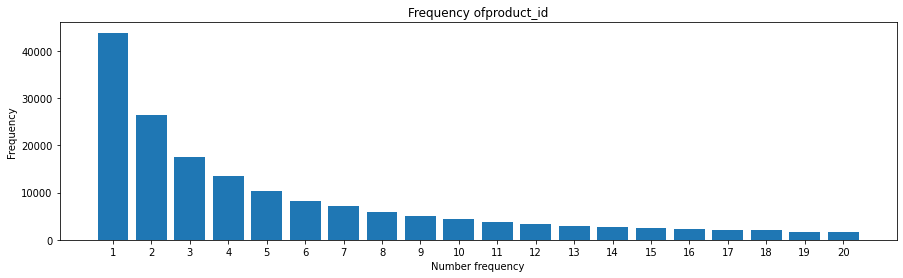

In [21]:
plot_sparse(df, 'product_id')

2021-03-19 16:23:40,298 [INFO]  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-03-19 16:23:40,300 [INFO]  Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


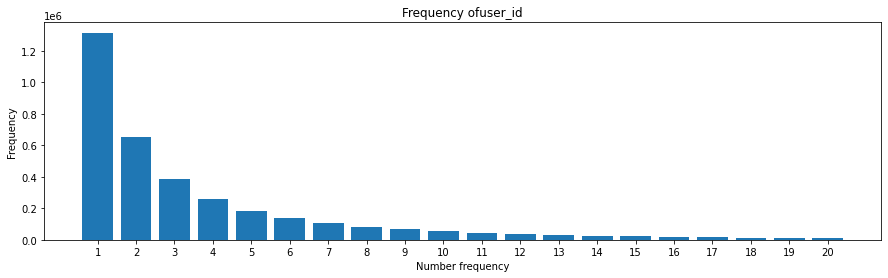

In [22]:
plot_sparse(df, 'user_id')

# Data Preprocessing

#### Missing Values
NA is not detected as missing values in python, therefore we need to replace NA with NaN

In [11]:
df_train.replace('NA', np.nan, inplace=True)

In [12]:
#Calculate missing values 
def missing_values(df):
  amount_missing = ((df.isnull()|df.isna()).sum())
  percent_missing = amount_missing*100/len(df)
  missing_value_df = pd.DataFrame({'column name':df.columns,
                                   'amount missing':amount_missing,
                                   'percentage':percent_missing})
  missing_value_df.sort_values('percentage', ascending=False, inplace=True)
  print(missing_value_df)

missing_values(df_train)

2021-03-19 15:41:48,899 [INFO]  NumExpr defaulting to 2 threads.


               column name  amount missing  percentage
cat_3                cat_3        11488757   99.943585
cat_2                cat_2         5071243   44.116018
cat_1                cat_1         1527738   13.290177
cat_0                cat_0         1527738   13.290177
brand                brand          949132    8.256738
user_session  user_session              66    0.000574
timestamp        timestamp               0    0.000000
ts_month          ts_month               0    0.000000
ts_day              ts_day               0    0.000000
ts_weekday      ts_weekday               0    0.000000
ts_minute        ts_minute               0    0.000000
ts_hour            ts_hour               0    0.000000
event_time      event_time               0    0.000000
event_type      event_type               0    0.000000
target              target               0    0.000000
user_id            user_id               0    0.000000
price                price               0    0.000000
product_id

What to do with missing values?

There are several options
1. Impute by a unique pointer like `unknown` for categorical values
2. Impute missing value by using descriptive statistics (mean, median, etc)
3. Impute missing values by using deep learning
4. Impute missing values by using Extended Isolation Forest algorithm


In [ ]:
columns = ['brand', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 'user_session']

for i in columns:
  df_train['NA_' + i] = df_train[i].isna().astype(np.int8)
  df_train[i].fillna('UNKNOWN', inplace=True)

In [ ]:
df_train.isna().sum()

event_time         0
event_type         0
product_id         0
brand              0
price              0
user_id            0
user_session       0
target             0
cat_0              0
cat_1              0
cat_2              0
cat_3              0
timestamp          0
ts_hour            0
ts_minute          0
ts_weekday         0
ts_day             0
ts_month           0
ts_year            0
NA_brand           0
NA_cat_0           0
NA_cat_1           0
NA_cat_2           0
NA_cat_3           0
NA_user_session    0
dtype: int64

In [ ]:
df_train[['brand', 'target']].groupby(['brand']).agg(['mean', 'count']).sort_values(('target', 'count'), ascending=False).head(10)

target         
             mean    count
brand                     
samsung  0.436938  2329847
apple    0.418314  2040287
xiaomi   0.337278  1085216
UNKNOWN  0.299585   949132
huawei   0.429172   358290
oppo     0.462092   155283
lg       0.344652   153668
lucente  0.451764   152396
sony     0.349111   141342
artel    0.337901   110571

#### Imputation using Deep Learning